# Bank International Settlement - Data Pipeline
__Team 6 - Lane Whitmore and Dave Friesen__<br>
__ADS-507-02-SP23__<br><br>
__GitHub link: https://github.com/lanewhitmore/BIS_Data_Pipeline__

In [1]:
__authors__ = ['Lane Whitmore', 'Dave Friesen']
__contact__ = ['lwhitmore@sandiego.edu', 'dfriesen@sandiego.edu']
__date__ = '2023-02-04'
__license__ = 'MIT'
__version__ = '1.0.1'

# Setup

In [2]:
# Import basic and data access libraries
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import pymysql
pymysql.install_as_MySQLdb()

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

# Import utility libraries
import urllib
import zipfile
import logging
import os
from datetime import datetime
import warnings

In [3]:
# Set database defaults
_host = os.environ.get('HOST')
_user = os.environ.get('USER')
_port = int(os.environ.get('PORT'))
_passwd = os.environ.get('PASSWORD')
_db = os.environ.get('DB_NAME')

In [4]:
# Setup logging
logging.basicConfig(filename='pipeline.log', filemode='w', force=True,
                   format='%(asctime)s:%(levelname)s:%(message)s')
pipeline_log = logging.getLogger('pipeline_log')
pipeline_log.setLevel(logging.INFO)

In [5]:
# Set basic np, pd, and plt output defaults
%run -i 'defaults.py'

# Data Extract and Load

In [6]:
def ctrl_count(fname):
    """
    Get simple file row count for data load confirmation
    """
    f = open(fname)
    count = sum(1 for line in f)
    f.close()
    return count

def download_and_extract_data(url, filename, path):
    """
    Download file from specified URL and extract to specified path;
        True if successful, otherwise False
    """
    try:
        urllib.request.urlretrieve(url, os.path.join(path, filename))
        pipeline_log.info(filename+' retrieved')
        with zipfile.ZipFile(os.path.join(path, filename), 'r') as zip:
            zip.extractall(path)
        pipeline_log.info(filename+' extracted')
        return True
    except (urllib.error.HTTPError, urllib.error.HTTPException, urllib.error.URLError,
            FileNotFoundError, zipfile.BadZipFile, zipfile.LargeZipFile) as e:
        pipeline_log.error(f'{filename} error: {e}')
        return False
    
def load_data(filename, path, id_vars):
    """
    Load CSV into dataframe and return ID and value subsets;
        This is so that the pivoted values don't repeat all of the IDs unecessarily
        Both subsets retain the original index so can be joined that way in further
        processing
    """
    df = pd.read_csv(os.path.join(path, filename), on_bad_lines='skip', low_memory=False)
    df_ids = df.iloc[:, id_vars]
    df_values = df.iloc[:, max(id_vars)+1:]
    df_values = df_values.reset_index()
    df_values['index'] = df_values['index'] + 1
    df_values = pd.melt(df_values, id_vars='index', value_vars=df_values.iloc[:, 1:])
    return df, df_ids, df_values

In [7]:
# Define file location
url = 'https://www.bis.org/statistics/'

# Define dataset details
ds = {'exr': {'efname': 'full_xru_csv.zip',  # Name of file at above url
              'lfname': 'WS_XRU_csv_col.csv',  # Name of unzipped file
              'id_vars': range(0, 17)},  # ID (vs. value) columns
      'cp': {'efname': 'full_long_cpi_csv.zip',
             'lfname': 'WS_LONG_CPI_csv_col.csv',
             'id_vars': range(0, 15)},
      'pr': {'efname': 'full_cbpol_m_csv.zip',
             'lfname': 'WS_CBPOL_M_csv_col.csv',
             'id_vars': range(0, 14)}}

# Establish dataframe dictionaries - these are accessible by dataset abbreviation and
#   this allows for consistent code with flexibility
df = {'exr': None, 'cp': None, 'pr': None}  # To be used for full dataframe
df_ids = {'exr': None, 'cp': None, 'pr': None}  # To be used for subset of IDs only
df_values = {'exr': None, 'cp': None, 'pr': None}  # To be used for subset of values only

# Define download (extract) and load location - In this example, it assumes that the
#   default (code) directory is 'src', and that a 'data' directory exists in parallel;
#   this can be configured to anything
ds_path = '../data/'

In [8]:
# Iterate dataset
for dataset in ds:
    # Show we're doing something
    print('Processing '+ds[dataset]['efname'], end='... ')

    # Download and extract file; if error, log and skip to next file in dataset
    if not download_and_extract_data(url + ds[dataset]['efname'], ds[dataset]['efname'], ds_path):
        continue

    # Load dataframe
    df[dataset], df_ids[dataset], df_values[dataset] = load_data(ds[dataset]['lfname'],
                                                                 ds_path, ds[dataset]['id_vars'])

    # Confirm control counts
    ctrl = ctrl_count(ds_path+ds[dataset]['lfname'])
    pipeline_log.info('{0}_file={1}_import={2}_delta={3}'. \
                      format(ds[dataset]['lfname'], ctrl, len(df[dataset]), ctrl-len(df[dataset])))

    # If control count is off by more than one row (i.e., assuming header),
    #   log as warning
    if (ctrl - len(df[dataset])) > 1:
        pipeline_log.warning('control total exception')
        
    print()

Processing full_xru_csv.zip... 
Processing full_long_cpi_csv.zip... 
Processing full_cbpol_m_csv.zip... 


# Data Transformation

In [9]:
### Renaming key columns to be imported into the schema to make them more workable within MySQL
df_ids['exr'] = df_ids['exr'].copy()  # added to avoid SettingWithCopyWarning
df_ids['exr'].rename(columns = {'Frequency': 'frequency', 'Reference area': 'reference_area', 'Currency': 'currency', 
                                'Collection': 'collection', 'Unit Multiplier': 'unit_multiplier', 'DECIMALS': 'decimals',
                                'Availability': 'availability', 'TITLE': 'title', 'Series': 'series'}, inplace = True)

df_ids['pr'] = df_ids['pr'].copy()  # added to avoid SettingWithCopyWarning
df_ids['pr'].rename(columns = {'Frequency': 'frequency', 'DECIMALS': 'decimals', 'SOURCE_REF': 'source_ref', 'SUPP_INFO_BREAKS': 'supp_info_breaks',
                               'TITLE': 'title', 'Series': 'series'}, inplace = True)

df_ids['cp'] = df_ids['cp'].copy()  # added to avoid SettingWithCopyWarning
df_ids['cp'].rename(columns = {'Frequency': 'frequency', 'Reference area': 'reference_area', 'Unit of measure': 'unit_of_measure',
                               'Series':'series'}, inplace = True)

df_values['exr'].rename(columns = {'index': 'exchange_rate_id', 'variable': 'date'}, inplace = True)
df_values['pr'].rename(columns = {'index': 'policy_rate_id', 'variable': 'date'}, inplace = True)
df_values['cp'].rename(columns = {'index': 'consumer_prices_id', 'variable': 'date'}, inplace = True)

In [10]:
### Creating connection to local machine // formulas to nest df to 
def run_connection(db_connection: pymysql, syntax: str) -> None:
    """
    Run Syntax.

    :param db_connection: DB connection object. 
    :param syntax: Syntax for database connection execution.
    """
    cur = db_connection.cursor()
    cur.execute(syntax)
    cur.close()

### Can create a table if need be within notebook
def create_table(schema: str, table: str) -> None:
    """
    Create a new table in the connected database on the schema

    :param schema: The schema for the table.
    :param table: The name of the table within the schema.
    """
    db_conn = pymysql.connect(
        host=_host,
        user=_user,
        port=_port, 
        passwd=_passwd, 
        db=_db,
    )
    run_connection(db_connection=db_conn, syntax=f"CREATE TABLE IF NOT EXISTS {table}({schema})")

    db_conn.commit()
    db_conn.close()

### populate the table with new records
def populate_table(table_name: str, df: pd.DataFrame) -> None:
    """ 
    Insert df into table within database

    :param table_name: Name of the table within the DB
    :param df: df to be inserted into schema/DB
    """

    # Ignore known sqlalchemy warning
    warnings.filterwarnings('ignore')    
    
    db_data = 'mysql+mysqldb://'+os.environ.get("USER")+':'+os.environ['PASSWORD']+'@'+os.environ.get("HOST")+':3306/'+os.environ.get("DB_NAME")+'?charset=utf8mb4'
    engine = create_engine(db_data)
    db_conn = pymysql.connect(
        host=_host,
        user=_user,
        port=_port, 
        passwd=_passwd, 
        db=_db,
    )

    ### connecting to cursor to pull column names in table
    cur = db_conn.cursor()
    cur.execute(f"SELECT * FROM {table_name} LIMIT 0")
    cur.close()

    ### obtaining table column names
    col_names = [i[0] for i in cur.description]

    ### Ensure that updates do not duplicate by syncing table indexes and dataframe indexes
    index1 = pd.read_sql(f"SELECT {table_name}_id FROM {table_name};", db_conn).index
    index2 = df.index
    indiff = index2.difference(index1)

    ### Extracting indexes not seen in table on database
    df = df.loc[indiff]

    ### Setting null value to be set auto incrementally
    df[f"{table_name}_id"] = np.NaN * len(df.index)

    ### Identify missing columns
    missing_columns = set(col_names).difference(df.columns)
    #assert not missing_columns, f"The columns listed are missing from your dataset: {','.join(missing_columns)}"

    pipeline_log.info(table_name+' population executed')
#    pipeline_log.info(df, missing_columns)
    
    if len(missing_columns) > 0:
        pipeline_log.error('Missing Columns Critical Error')

    ### extracting needed columns from dataframes
    df = df[col_names]

    df.to_sql(table_name, engine, if_exists = 'append', index = False)
    db_conn.commit()
    engine.dispose()
    db_conn.close()

    warnings.resetwarnings()

In [11]:
### Table names from Schema for ID
table_names = ['exchange_rate','consumer_prices','policy_rate']
value_table_names = ['exchange_rate_values','consumer_prices_values','policy_rate_values']

for i in zip(df_ids, table_names):
    print('Populating ' + i[1] + ' with ' + i[0], end='... ')

    populate_table(table_name= i[1], df = df_ids[i[0]])

    print()

for i in zip(df_values, value_table_names):
    print('Populating ' + i[1] + ' with ' + i[0], end='... ')

    populate_table(table_name= i[1], df = df_values[i[0]])

    print()

Populating exchange_rate with exr... 
Populating consumer_prices with cp... 
Populating policy_rate with pr... 
Populating exchange_rate_values with exr... 
Populating consumer_prices_values with cp... 
Populating policy_rate_values with pr... 


# Data Consumption

## Establish CPI and Fed Rate Dataframes

In [12]:
# Create connection to the MySQL server
conn = pymysql.connect(host=_host, user=_user, passwd=_passwd, db=_db)

# Filter innocuous sqlalchemy warnings
warnings.filterwarnings('ignore')    

# Create Consumer Price Index (CPI) dataframe for select time frame
q = 'SELECT \
        cp.reference_area AS cp_reference_area \
        , cpv.date AS cpv_date \
        , cpv.value AS cpv_value \
    FROM consumer_prices cp \
    INNER JOIN consumer_prices_values cpv ON cp.consumer_prices_id = cpv.consumer_prices_id \
    WHERE \
        cp.reference_area LIKE \'United States%\' \
        AND cp.frequency = \'Monthly\' \
        AND cp.unit_of_measure = \'Year-on-year changes, in per cent\' \
        AND LENGTH(cpv.date) = 7 \
        AND CAST(SUBSTR(cpv.date, 1, 4) AS UNSIGNED) BETWEEN 1980 AND 2022 \
    ORDER BY 2, 3;'
print('Creating cpi_df', end='... ')
try:
    cpi_df = pd.read_sql(q, conn)
    cpi_df['cpv_date'] = pd.to_datetime(cpi_df['cpv_date'])
    pipeline_log.info('cpi_df created')
except Exception as e:
    pipeline_log.error(f'cpi_df error: {e}')
print()

# Create US Fed Rate dataframe for same time frame as CPI above
q = 'SELECT \
        prv.date AS prv_date \
        , prv.value AS prv_value \
    FROM policy_rate pr \
    INNER JOIN policy_rate_values prv ON pr.policy_rate_id = prv.policy_rate_id \
    WHERE \
        pr.source_ref = \'US Federal Reserve System\' \
        AND pr.frequency = \'Monthly\' \
        AND LENGTH(prv.date) = 7 \
        AND CAST(SUBSTR(prv.date, 1, 4) AS UNSIGNED) BETWEEN 1980 AND 2022 \
    ORDER BY 1, 2;'
print('Creating fedrate_df', end='... ')
try:
    fedrate_df = pd.read_sql(q, conn)
    fedrate_df['prv_date'] = pd.to_datetime(fedrate_df['prv_date'])
    pipeline_log.info('fedrate_df created')
except Exception as e:
    pipeline_log.error(f'fedrate_df error: {e}')
print()

# Close MySQL connection
conn.close()

# Reset warnings to default
warnings.resetwarnings()

Creating cpi_df... 
Creating fedrate_df... 


## [. . .]

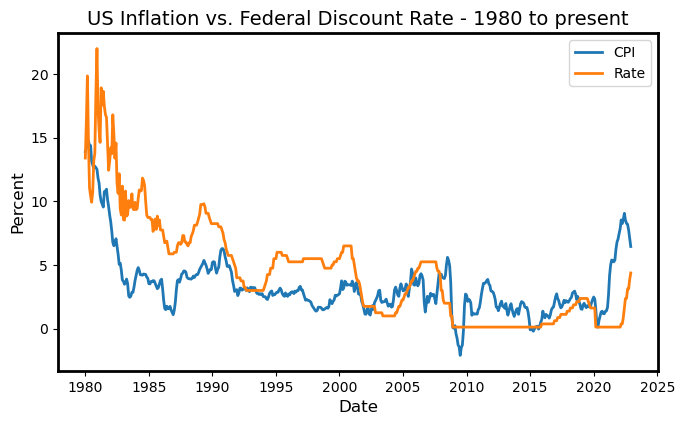

In [13]:
# Plot ratings and film counts
fig, ax = plt.subplots()
ax.plot(cpi_df['cpv_date'], cpi_df['cpv_value'], label='CPI')
ax.plot(fedrate_df['prv_date'], fedrate_df['prv_value'], label='Rate')

# Set plot titles, axis labels, and legend
plt.title('US Inflation vs. Federal Discount Rate - 1980 to present')
plt.xlabel('Date')
plt.ylabel('Percent')
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.legend()

# Show plot
plt.show()

# Wrap-up

In [14]:
# Cleanly close logging
logging.shutdown()